<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/train%20eye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.models import Sequential

## เตรียมชุดของข้อมูล

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')
path = '/content/drive/My Drive/Eyedata'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

Mounted at /content/drive


In [3]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/Eyedata')

In [4]:
batch_size = 20    # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 434   # ความสูงของรูปภาพแต่ละรูป
img_width = 767    # ความกว้างของรูปภาพแต่ละรูป

## Train

In [5]:
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.2, # s แบ่งข้อมูล เพื่อ training 80% และ validation 20%
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
val = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 3202 files belonging to 3 classes.
Using 2562 files for training.
Found 3202 files belonging to 3 classes.
Using 640 files for validation.


In [6]:
class_names = train.class_names
print(class_names)

['CSC', 'PCV', 'VKH']


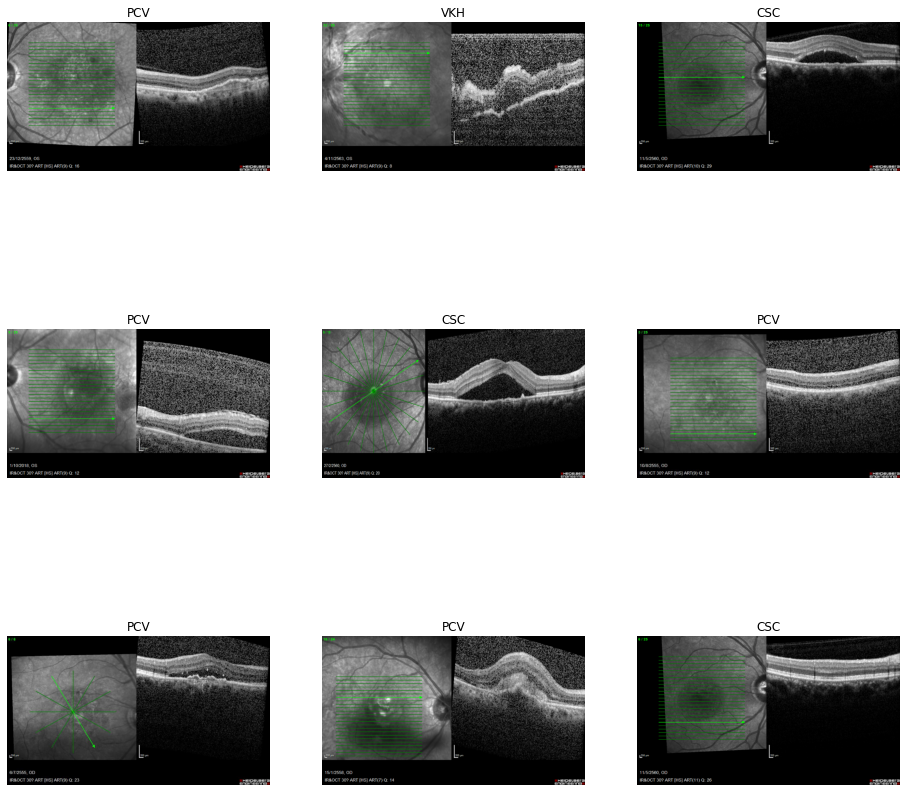

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(15, 224, 224, 3)
(15,)


## Normalization

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Model

In [ ]:
num_classes = 5
epochs=10   # จำนวนครั้งที่เราจะ Train

In [ ]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
his = model.fit(
train,
validation_data=val,
epochs=epochs
)

Epoch 1/10
220/292 [=====================>........] - ETA: 3:54 - loss: 0.9233 - accuracy: 0.5682

KeyboardInterrupt: ignored

## Save Model

In [ ]:
with open(‘history_model’, ‘wb’) as file:
p.dump(his.history, file)

filepath=’model1.h5'
model.save(filepath)
filepath_model = ‘model1.json’
filepath_weights = ‘weights_model.h5’
model_json = model.to_json()
with open(filepath_model, “w”) as json_file:
json_file.write(model_json)

model.save_weights(‘weights_model.h5’)
print(“Saved model to disk”)

## Load Model

In [ ]:
with open(‘history_model’, ‘rb’) as file:
his = p.load(file)

h1 = go.Scatter(y=his[‘loss’],
mode=”lines”, line=dict(
width=2,
color=’blue’),
name=”loss”
)
h2 = go.Scatter(y=his[‘val_loss’],
mode=”lines”, line=dict(
width=2,
color=’red’),
name=”val_loss”
)

data = [h1,h2]
layout1 = go.Layout(title=’Loss’,
xaxis=dict(title=’epochs’),
yaxis=dict(title=’’))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename=”testMNIST”)
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, ‘r’) as f:
loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print(“Loaded model from disk”)

## Prediction

In [ ]:
import requests
from IPython.display import Image
from io import BytesIO
test_path = (‘D:/a1.jpg’)
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(“apple”,score[0],”banana”,score[1],”mangosteen”,score[2],”orange”,score[3],”pineapple”,score[4])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
fruit = “apple”
elif score[1]==np.max(score) :
fruit = “banana”
elif score[2]==np.max(score) :
fruit = “mangosteen”
elif score[3]==np.max(score) :
fruit = “orange”
elif score[4]==np.max(score) :
fruit = “pineapple”
print(
“AI {} มีความมั่นใจ {:.2f}%.”
.format(fruit, 100 * np.max(score))
)